In [1]:
%cd /home/smalani/Cybernetic/growthcurvefit/
import pandas as pd

/home/smalani/Cybernetic/growthcurvefit


In [2]:
df = pd.read_csv('/home/smalani/Cybernetic/growthcurvefit/data/Data_For_Importation.csv')
df.head()

df['M0'] = df['M0'] * 10 / 6
df['M1'] = df['M1'] * 10 / 6
df['M2'] = df['M2'] * 10 / 6
df['M3'] = df['M3'] * 10 / 6
df['M4'] = df['M4'] * 10 / 6
df['M5'] = df['M5'] * 10 / 6
df['M6'] = df['M6'] * 10 / 6
df['M7'] = df['M7'] * 10 / 6


In [3]:
df_par = pd.read_csv('/home/smalani/Cybernetic/growthcurvefit/data/LightParameter.csv')
print(df_par.head())
print(df_par)

df_dict = df_par.to_dict('list')


   M0  M1    M2    M3   M4   M5  M6  M7
0   0   0  0.01  0.01  0.1  0.1   1   1
   M0  M1    M2    M3   M4   M5  M6  M7
0   0   0  0.01  0.01  0.1  0.1   1   1


In [4]:
df_par.nunique(axis=1)[0]

4

In [5]:
def growthfun(t,x,p):

    # Parameters
    mu_max, Ks, Y = p

    # Variables
    S, X = x
    
    
    mu = mu_max * S / (Ks + S)

    dSdt = - (mu / Y) * X
    dXdt = mu * X

    return [dSdt, dXdt]

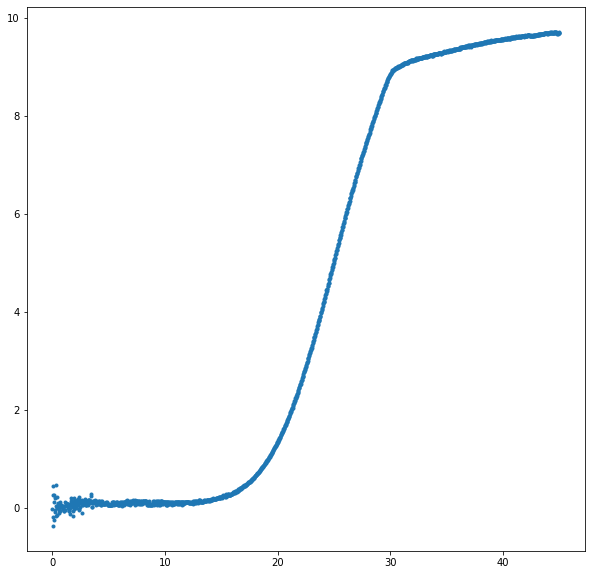

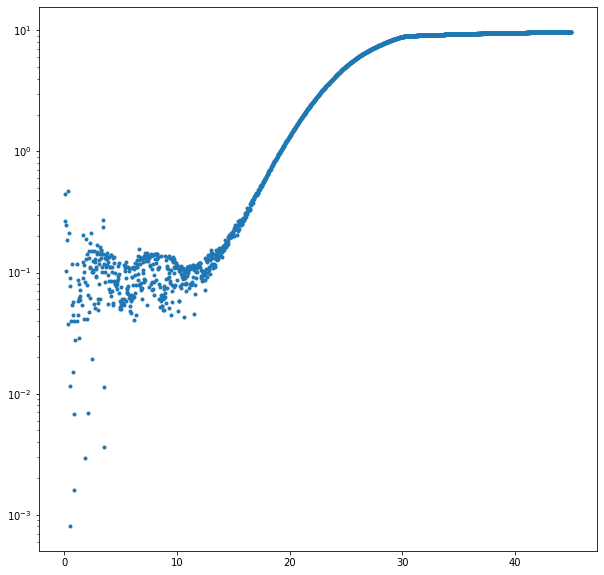

In [6]:
import matplotlib.pyplot as plt



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(df['Time'], df['M0'], '.', label='M0')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.semilogy(df['Time'], df['M0'], '.', label='M0')

In [7]:
import numpy as np
from scipy.integrate import solve_ivp

def fsolvefun(pars):
    X0, mu_max, Ks, Y = pars

    xinit = [2, 0.01]
    # tspan = [df['Time'].iloc[0], df['Time'].iloc[-1]]
    tspan = [X0, df['Time'].iloc[-1]]


    par_fit = [mu_max, Ks, Y]

    sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > X0], rtol=1e-6, atol=1e-9)

    return np.mean((sol.y[1,:] - df['M0'][df['Time'] > X0]) ** 2) #+ Ks * 0.01

In [8]:
print(df['Time'].iloc[-1])

45.01117778


In [9]:
from scipy.optimize import minimize

fsolve_guess = [0.1, 0.1, 0.1, 0.1]
fsolve_sol = minimize(fsolvefun, fsolve_guess, method='L-BFGS-B', bounds=((0, None), (0, None), (0, None), (0, None)))

print(fsolve_sol)


      fun: 0.0062210382003750515
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.38398929e-04,  6.93895379e-04, -9.93946163e-05, -3.39684793e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 325
      nit: 25
     njev: 65
   status: 0
  success: True
        x: array([ 6.58905566,  2.89472709, 13.49883312,  4.78111445])


/home/smalani/.conda/envs/torch-env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


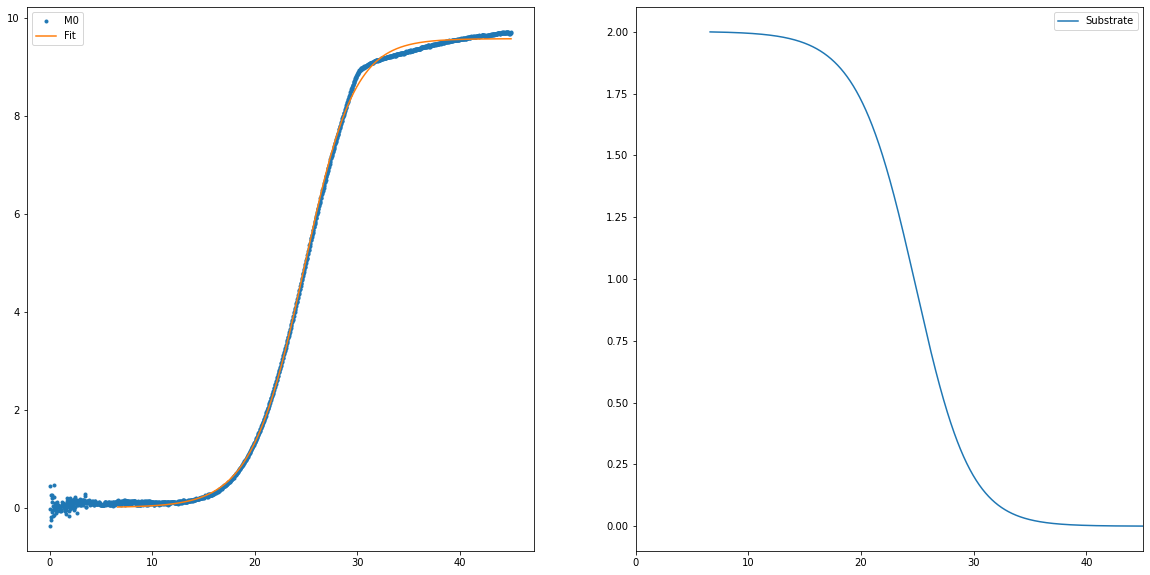

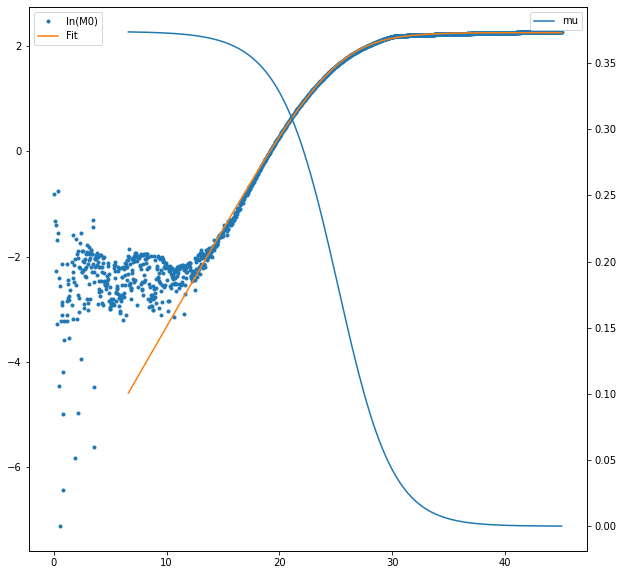

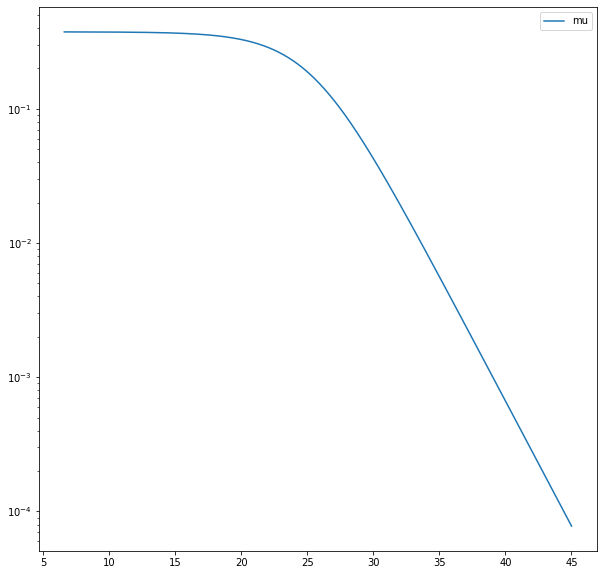

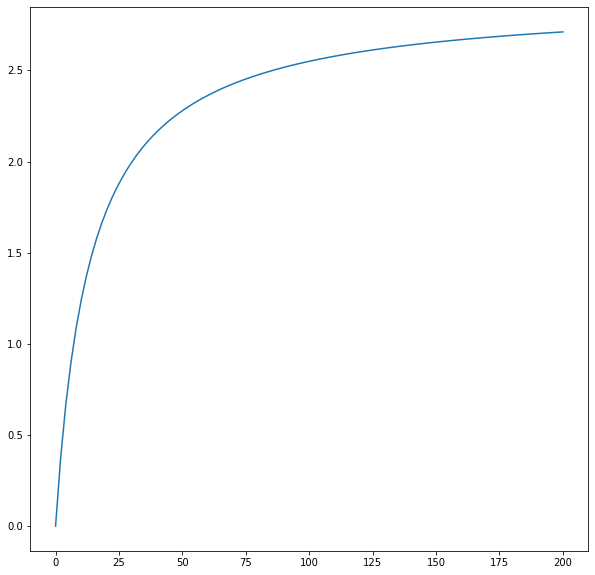

In [10]:
import matplotlib.pyplot as plt

xinit = [2, 0.01]
# tspan = [df['Time'].iloc[0], df['Time'].iloc[-1]]

tspan = [fsolve_sol.x[0], df['Time'].iloc[-1]]
sol = solve_ivp(growthfun, tspan, xinit, args=(fsolve_sol.x[1:],), method='BDF', t_eval=df['Time'][df['Time'] > fsolve_sol.x[0]], rtol=1e-6, atol=1e-9)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(df['Time'], df['M0'], '.', label='M0')
ax.plot(sol.t, sol.y[1,:], label='Fit')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(sol.t, sol.y[0,:], label='Substrate')
ax.set_xlim([0, df['Time'].iloc[-1]])
plt.legend()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(df['Time'], np.log(df['M0']), '.', label='ln(M0)')
ax.plot(sol.t, np.log(sol.y[1,:]), label='Fit')
plt.legend()

ax2 = ax.twinx()
ax2.plot(sol.t, fsolve_sol.x[1] * sol.y[0,:] / (fsolve_sol.x[2] + sol.y[0,:]), label='mu')
plt.legend()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.semilogy(df['Time'], df['M0'], '.', label='M0')
ax.semilogy(sol.t, fsolve_sol.x[1] * sol.y[0,:] / (fsolve_sol.x[2] + sol.y[0,:]), label='mu')
plt.legend()

mu_fun = lambda S: fsolve_sol.x[1] * S / (fsolve_sol.x[2] + S)
S_arr = np.linspace(0,200,100)
mu_arr = mu_fun(S_arr)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(S_arr, mu_arr, label='Monod')

In [11]:
import numpy as np
from scipy.integrate import solve_ivp

# def fsolvefun(pars):
#     X0, mu_max, Ks, Y = pars

#     xinit = [2, 0.01]
#     # tspan = [df['Time'].iloc[0], df['Time'].iloc[-1]]
#     tspan = [X0, df['Time'].iloc[-1]]


#     par_fit = [mu_max, Ks, Y]

#     sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > X0], rtol=1e-6, atol=1e-9)

#     return np.mean((sol.y[1,:] - df['M0'][df['Time'] > X0]) ** 2) #+ Ks * 0.01

def fsolvefun(pars):
    t_0, t_1, t_10, t_100, mu_max_0, mu_max_1, mu_max_10,mu_max_100, Ks, Y = pars
    error = 0

    xinit = [2, 0.01]


    par_fit = [mu_max_0, Ks, Y]
    tspan = [t_0, df['Time'].iloc[-1]]
    sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > t_0], rtol=1e-6, atol=1e-9)
    error += np.mean((sol.y[1,:] - df['M0'][df['Time'] > t_0]) ** 2)
    error += np.mean((sol.y[1,:] - df['M1'][df['Time'] > t_0]) ** 2)

    par_fit = [mu_max_1, Ks, Y]
    tspan = [t_1, df['Time'].iloc[-1]]
    sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > t_1], rtol=1e-6, atol=1e-9)
    error += np.mean((sol.y[1,:] - df['M2'][df['Time'] > t_1]) ** 2)
    error += np.mean((sol.y[1,:] - df['M3'][df['Time'] > t_1]) ** 2)

    par_fit = [mu_max_10, Ks, Y]
    tspan = [t_10, df['Time'].iloc[-1]]
    sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > t_10], rtol=1e-6, atol=1e-9)
    error += np.mean((sol.y[1,:] - df['M4'][df['Time'] > t_10]) ** 2)
    error += np.mean((sol.y[1,:] - df['M5'][df['Time'] > t_10]) ** 2)

    par_fit = [mu_max_100, Ks, Y]
    tspan = [t_100, df['Time'].iloc[-1]]
    sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > t_100], rtol=1e-6, atol=1e-9)
    error += np.mean((sol.y[1,:] - df['M6'][df['Time'] > t_100]) ** 2)
    error += np.mean((sol.y[1,:] - df['M7'][df['Time'] > t_100]) ** 2)

    return error

In [12]:
fsolve_guess = [0, 0, 0, 0,
                  2.89472016, 2.89472016, 2.89472016/2, 2.89472016/5,
                  13.49879505,  4.78111456]
bounds = ((0, 15), (0, 15), (0, 15), (0, 15),
          (0, None), (0, None), (0, None), (0, None),
          (0, None), (0, None))
fsolve_sol = minimize(fsolvefun, fsolve_guess, method='L-BFGS-B', bounds=bounds)#, options={'eps': 1e-11})
print(fsolve_sol)

      fun: 0.823580658058309
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00369216, -0.00471545, -0.01930947,  0.00095211,  0.00321081,
        0.0025302 ,  0.01988818, -0.01858369, -0.00127929,  0.00158051])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1639
      nit: 40
     njev: 149
   status: 2
  success: False
        x: array([7.99583022e+00, 5.24125446e+00, 2.72446175e+00, 1.44711400e-02,
       3.91714023e+00, 3.51824948e+00, 1.70837023e+00, 7.80779562e-01,
       1.68613020e+01, 4.86771374e+00])


Text(0, 0.5, 'mu[t=0]')

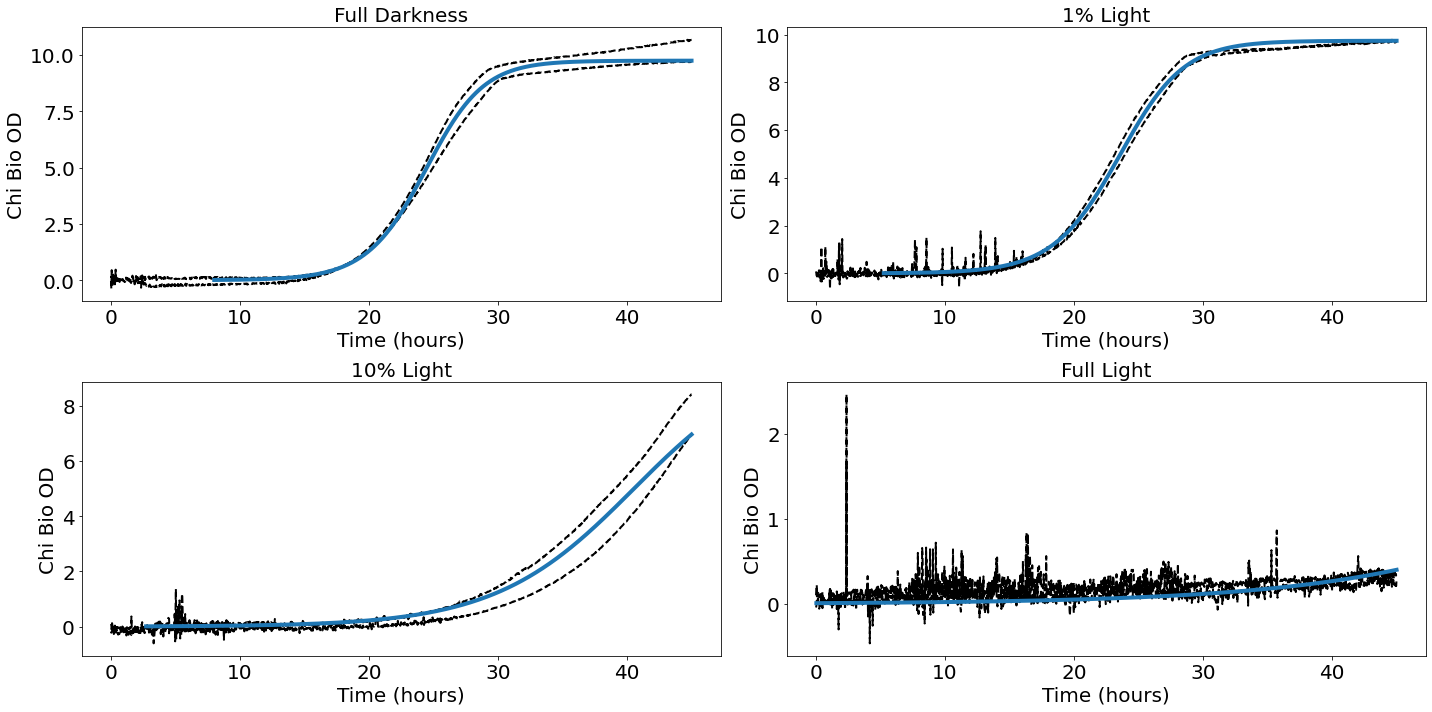

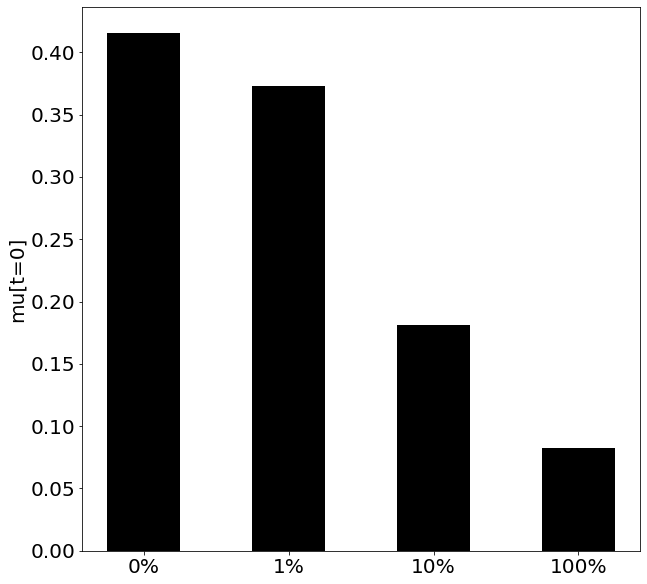

In [15]:
import matplotlib.pyplot as plt

t_0, t_1, t_10, t_100, mu_max_0, mu_max_1, mu_max_10,mu_max_100, Ks, Y = fsolve_sol.x

my_mu0 = mu_max_0 * 2 / (fsolve_sol.x[-2] + 2)
my_mu1 = mu_max_1 * 2 / (fsolve_sol.x[-2] + 2)
my_mu10 = mu_max_10 * 2 / (fsolve_sol.x[-2] + 2)
my_mu100 = mu_max_100 * 2 / (fsolve_sol.x[-2] + 2)

xinit = [2, 0.01]

par_fit = [mu_max_0, Ks, Y]
tspan = [t_0, df['Time'].iloc[-1]]
sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > t_0], rtol=1e-6, atol=1e-9)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(221)
ax.plot(df['Time'], df['M0'], 'k--', label='M0', linewidth=2)
ax.plot(df['Time'], df['M1'], 'k--', label='M1', linewidth=2)
ax.plot(sol.t, sol.y[1,:], label='Fit', linewidth=4)
ax.set_xlabel('Time (hours)', fontsize=20)
ax.set_ylabel('Chi Bio OD', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Full Darkness', fontsize=20)

par_fit = [mu_max_1, Ks, Y]
tspan = [t_1, df['Time'].iloc[-1]]
sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > t_1], rtol=1e-6, atol=1e-9)
ax = fig.add_subplot(222)
ax.plot(df['Time'], df['M2'], 'k--', label='M2', linewidth=2)
ax.plot(df['Time'], df['M3'], 'k--', label='M3', linewidth=2)
ax.plot(sol.t, sol.y[1,:], label='Fit', linewidth=4)
ax.set_xlabel('Time (hours)', fontsize=20)
ax.set_ylabel('Chi Bio OD', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('1% Light', fontsize=20)

par_fit = [mu_max_10, Ks, Y]
tspan = [t_10, df['Time'].iloc[-1]]
sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > t_10], rtol=1e-6, atol=1e-9)
ax = fig.add_subplot(223)
ax.plot(df['Time'], df['M4'], 'k--', label='M4', linewidth=2)
ax.plot(df['Time'], df['M5'], 'k--', label='M5', linewidth=2)
ax.plot(sol.t, sol.y[1,:], label='Fit', linewidth=4)
ax.set_xlabel('Time (hours)', fontsize=20)
ax.set_ylabel('Chi Bio OD', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('10% Light', fontsize=20)

par_fit = [mu_max_100, Ks, Y]
tspan = [t_100, df['Time'].iloc[-1]]
sol = solve_ivp(growthfun, tspan, xinit, args=(par_fit,), method='BDF', t_eval=df['Time'][df['Time'] > t_100], rtol=1e-6, atol=1e-9)
ax = fig.add_subplot(224)
ax.plot(df['Time'], df['M6'], 'k--', label='M6', linewidth=2)
ax.plot(df['Time'], df['M7'], 'k--', label='M7', linewidth=2)
ax.plot(sol.t, sol.y[1,:], label='Fit', linewidth=4)
ax.set_xlabel('Time (hours)', fontsize=20)
ax.set_ylabel('Chi Bio OD', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Full Light', fontsize=20)

plt.tight_layout()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.bar([0,1,2,3], [my_mu0, my_mu1, my_mu10, my_mu100], width=0.5, color='k')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['0%','1%','10%','100%'], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('mu[t=0]', fontsize=20)